# Set-up

### Imports

In [1]:
import math
import random
import json
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18 # set font size
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

import torch
import torch.nn as nn
from torch.nn import MSELoss, BCEWithLogitsLoss, CrossEntropyLoss

from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import TextClassificationPipeline
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput

device = torch.device("cpu")


In [2]:
# Set folders
# dir_models =   Path(r'C:\Users\rldek\Mijn Drive (TiU)\Thesis\Code\thesis-msc-data-science\models')

dir_models = Path(r'C:\Users\rldek\Downloads\downloaded models')

dir_data =     Path(r'C:\Users\rldek\Mijn Drive (TiU)\Thesis\Code\thesis-msc-data-science\data')
dir_diagrams = Path(r'C:\Users\rldek\Mijn Drive (TiU)\Thesis\Code\thesis-msc-data-science\diagrams')

##### For Google Colab

In [1]:
# # code for Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
# cd "drive/My Drive/thesis-robert"

/content/drive/My Drive/thesis-robert


In [5]:
# dir_models = Path('models')
# dir_data = Path('data')
# dir_diagrams = Path('diagrams')

In [6]:
# ! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [1]:
# ! pip install accelerate -U

  Using cached accelerate-0.31.0-py3-none-any.whl (309 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (9

### Model configs

In [3]:
experiments = {
    'bert_base_full': { # Base BERT model on full original dataset, reproduced from Luo et al.
        'output_name': 'bert_base_full',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'orig',
        'context_type': None,
        'custom_pooling': False
    },
    'bert_base_reduc': { # Base BERT model on reduced dataset (corresponding to samples available in augm. dataset)
        'output_name': 'bert_base_reduc',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'reduc',
        'context_type': None,
        'custom_pooling': False
    },
    'bert_aug_before': { # Model on augmented dataset, using '[CLS] context [SEP] sentence [SEP]' structure
        'output_name': 'bert_aug_before',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug_full',
        'context_type': 'before',
        'custom_pooling': False
    },
    'bert_aug_after': { # Model on augmented dataset, using '[CLS] sentence [SEP] context [SEP]' structure
        'output_name': 'bert_aug_after',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug_full',
        'context_type': 'after',
        'custom_pooling': False
    },
    'bert_aug_full': { # Model on augmented dataset, using average-pooling
        'output_name': 'bert_aug_full',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug_full',
        'context_type': 'full',
        'custom_pooling': True
    },
    'bert_aug_4': { # Model on augmented dataset, using average-pooling
        'output_name': 'bert_aug_4',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug_4',
        'context_type': 'full',
        'custom_pooling': True
    },
    'bert_aug_3': { # Model on augmented dataset, using average-pooling
        'output_name': 'bert_aug_3',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug_3',
        'context_type': 'full',
        'custom_pooling': True
    },
    'bert_aug_2': { # Model on augmented dataset, using average-pooling
        'output_name': 'bert_aug_2',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug_2',
        'context_type': 'full',
        'custom_pooling': True
    },
    'bert_aug_1': { # Model on augmented dataset, using average-pooling
        'output_name': 'bert_aug_1',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug_1',
        'context_type': 'full',
        'custom_pooling': True
    },
    'bert_base_avgpool': {
        'output_name': 'bert_base_avgpool',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'reduc',
        'context_type': None,
        'custom_pooling': True
    },

    'droberta_base': { # Base distilRoBERTa model to compare against Climate-model
        'output_name': 'droberta_base',
        'ckpt': "distilbert/distilroberta-base",
        'dataset_type': 'orig',
        'context_type': None,
        'custom_pooling': False
    },
    'droberta_climate': { # Climate model on full original dataset
        'output_name': 'droberta_climate',
        'ckpt': "climatebert/distilroberta-base-climate-f",
        'dataset_type': 'orig',
        'context_type': None,
        'custom_pooling': False
    },
}

### Global definitions and functions

In [4]:
# Define label dictionary for HuggingFace model config.json
label_names = ['disagree', 'agree', 'neutral']
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

def get_total_steps(experiment: dict) -> int:
    """Calculate total n steps of trainig config, based on n_epochs, n_samples and batch_size."""
    n_samples = len(experiment['dataset_enc']['train'])
    n_epochs = 7
    batch_size = 16

    steps_per_epoch = math.ceil(n_samples / batch_size)
    total_steps = steps_per_epoch * n_epochs

    return total_steps

def set_seed(seed:int, deterministic:bool=False) -> None:
    """Set random seed and disable deterministic algorithms for reproducability of results"""
    random.seed(int(seed))
    np.random.seed(seed)
    torch.manual_seed(seed)
    if deterministic:
        torch.use_deterministic_algorithms(mode=True) # mode=True -> throw runtime error if deterministic alternative not available

def get_y_pred(model_name:str, folder_path:str, subset:str = 'test'):
    """Return predicted y values on set for given model_name in given folder_path."""

    model = AutoModelForSequenceClassification.from_pretrained(folder_path, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained(folder_path)

    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)
    preds = pipe(experiments[model_name]['dataset_enc'][subset]['sentence'])

    return np.array([label2id[pred['label']] for pred in preds])

def get_y_pred_prob(model_name:str, folder_path:str, subset:str = 'test'):
    """Return predicted y probabilities for all classes, on set for given model_name in given folder_path."""

    model = AutoModelForSequenceClassification.from_pretrained(folder_path, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained(folder_path)

    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)
    preds = pipe(experiments[model_name]['dataset_enc'][subset]['sentence'])

    return np.array([[pred['score'] for pred in pred_probs] for pred_probs in preds])

def get_y_true(model_name:str, subset:str = 'test'):
    """Return true y values on set for given model_name"""

    return np.array(experiments[model_name]['dataset_enc'][subset]['label'])

def get_y_true_prob(model_name, subset:str='test'):
    """Return true y probabilities for each label for given model_name"""
    disagree = experiments[model_name]['dataset_enc'][subset]['disagree']
    agree    = experiments[model_name]['dataset_enc'][subset]['agree']
    neutral  = experiments[model_name]['dataset_enc'][subset]['neutral']
    return np.stack((disagree, agree, neutral), axis=1)

def get_y_true_one_hot(model_name: str, subset:str = 'test'):
    """Return true y values in 1-hot format, on set for given model_name"""
    y_true = np.array(experiments[model_name]['dataset_enc'][subset]['label'])
    return np.eye(3)[y_true]

def get_model_last_ckpt_path(model_name:str):

    last_ckpt_path = dir_models / model_name / f'checkpoint-{get_total_steps(experiments[model_name])}'
    if not last_ckpt_path.exists():
        raise FileNotFoundError("Folder does not exist. Perhaps the location is incorrect, or the model was not trained, or the checkpoint-step number is incorrect?")
    return last_ckpt_path

def get_model_log(model_name: str) -> dict:

    last_ckpt_path = get_model_last_ckpt_path(model_name)

    log_path = last_ckpt_path / 'trainer_state.json'
    if not log_path.exists():
        raise FileNotFoundError("'trainer_state.json' not found.")

    with open(log_path) as file:
        log = json.load(file)

    return log

def get_model_best_ckpt_path(model_name:str):

    log = get_model_log(model_name)

    best_ckpt_path = dir_models / Path(log['best_model_checkpoint'].replace('models/', ''))
    if not best_ckpt_path.exists():
        raise FileNotFoundError("Folder does not exist.")
    return best_ckpt_path

def make_conf_matrix(y_true,
                      y_pred,
                      labels: list,
                      save: bool = False,
                      folderpath: Path = dir_diagrams,
                      filename: str = 'conf_matrix'):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)

    if save:
        if not folderpath.exists():
            folderpath.mkdir(parents=True, exist_ok=True)
        plt.tight_layout()
        plt.savefig(folderpath / f'{filename}.png', dpi=600)

def make_classification_report(y_true,
                               y_pred,
                               labels: list,
                               save: bool = False,
                               folderpath: Path = dir_diagrams,
                               filename: str = 'classification_report'):

    print(classification_report(y_true, y_pred, target_names=labels))

    if save:
        if not folderpath.exists():
            folderpath.mkdir(parents=True, exist_ok=True)

        report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
        report.update({"accuracy": {"precision": None, "recall": None, "f1-score": report["accuracy"], "support": report['macro avg']['support']}})
        pd.DataFrame(report).transpose().to_excel(folderpath / f'{filename}.xlsx')

def get_log_metrics(log: dict) -> dict:
    '''Obtain metrics from log file created during training model'''
    log_metrics = {}
    for metric in ['eval_f1', 'eval_accuracy', 'eval_loss', 'loss']:
        log_metrics[metric] = {entry['epoch']: entry[metric] for entry in log['log_history'] if metric in entry}

    return log_metrics

def make_loss_per_epoch(log: dict, save: bool = False, folderpath: Path = dir_diagrams, filename: str = 'loss_per_epoch'):

    metrics = get_log_metrics(log)

    fig, ax = plt.subplots()
    for metric, name in zip(['eval_loss', 'loss'], ['Test', 'Train']):
        ax.plot( metrics[metric].keys(), metrics[metric].values(), label=name )

    ax.set_xticks(list(metrics['loss'].keys()))

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    if save:
        if not folderpath.exists():
            folderpath.mkdir(parents=True, exist_ok=True)
        fig.tight_layout()
        fig.savefig(folderpath / f'{filename}.png', dpi=600)

def make_roc_curve(y_true_one_hot,
                    y_pred_probs,
                    labels,
                    macro_avg: bool = True,
                    save: bool = False,
                    folderpath: Path = dir_diagrams,
                    filename: str = 'roc_curve'):

    fig, ax = plt.subplots()

    # get fpr, tpr per class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    # plot per class
    for i in range(3):
        ax.plot(fpr[i], tpr[i], label=f'{labels[i]} (area={roc_auc[i]:.2f})')

    if macro_avg:

        # construct and plot macro-average
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(3):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 3
        ax.plot(all_fpr, mean_tpr, label=f'Micro-average (area={auc(all_fpr, mean_tpr):.2f})', linestyle='--', color='black')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

    if save:
        if not folderpath.exists():
            folderpath.mkdir(parents=True, exist_ok=True)
        fig.tight_layout()
        fig.savefig(folderpath / f'{filename}.png', dpi=600)

### Datasets

In [5]:
data_file = dir_data / 'articles.pkl'

# Import and modify pandas dataframe
data_df = pd.read_pickle(data_file)

# Construct multiple context types
def get_context(row: pd.Series, context_type: str):
    if context_type == 'context_before':
        return f"{row['title']} : {row['sent-5']} {row['sent-4']} {row['sent-3']} {row['sent-2']} {row['sent-1']} {row['sent-0']}"
    elif context_type == 'context_after':
        return f"{row['sent+0']} {row['sent+1']} {row['sent+2']} {row['sent+3']} {row['sent+4']} {row['sent+5']}"
    else:
        return ''


for context_type in ['context_before', 'context_after']:
    data_df[context_type] = data_df.apply(lambda row: get_context(row, context_type), axis=1)

# Also construct context types with partial context
def get_context_partial(row: pd.Series, context_type: str):
    if context_type == 'context_before_4':
        return f"{row['sent-4']} {row['sent-3']} {row['sent-2']} {row['sent-1']} {row['sent-0']}"
    elif context_type == 'context_before_3':
        return f"{row['sent-3']} {row['sent-2']} {row['sent-1']} {row['sent-0']}"
    elif context_type == 'context_before_2':
        return f"{row['sent-2']} {row['sent-1']} {row['sent-0']}"
    elif context_type == 'context_before_1':
        return f"{row['sent-1']} {row['sent-0']}"
    elif context_type == 'context_after_4':
        return f"{row['sent+0']} {row['sent+1']} {row['sent+2']} {row['sent+3']} {row['sent+4']}"
    elif context_type == 'context_after_3':
        return f"{row['sent+0']} {row['sent+1']} {row['sent+2']} {row['sent+3']} {row['sent+4']}"
    elif context_type == 'context_after_2':
        return f"{row['sent+0']} {row['sent+1']} {row['sent+2']} {row['sent+3']} {row['sent+4']}"
    elif context_type == 'context_after_1':
        return f"{row['sent+0']} {row['sent+1']} {row['sent+2']} {row['sent+3']} {row['sent+4']}"
    else:
        return ''



for context_type in ['context_before_4', 'context_before_3', 'context_before_2', 'context_before_1',
                     'context_after_4', 'context_after_3', 'context_after_2', 'context_after_1']:
    data_df[context_type] = data_df.apply(lambda row: get_context_partial(row, context_type), axis=1)

# Split train-test
data_df_train = data_df[data_df['in_held_out_test'] == False].reset_index(drop=True)
data_df_test = data_df[data_df['in_held_out_test'] == True].reset_index(drop=True)  # test_set defined by Luo et al. and used for human baseline

# Select reduced size dataset (based on available samples for augmented dataset)
data_df_train_reduc = data_df_train[data_df_train['ok'] == True].reset_index(drop=True)
data_df_test_reduc = data_df_test[data_df_test['ok'] == True].reset_index(drop=True)

# Change dataframe to Transformers dataset type

# Define dataset features
features_dict = {
    'orig': Features({'sentence': Value('string'),
                      'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'reduc': Features({'sentence': Value('string'),
                      'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug_full': Features({'sentence': Value('string'),
                          'context_before': Value('string'),
                          'context_after': Value('string'),
                          'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug_4': Features({'sentence': Value('string'),
                          'context_before': Value('string'),
                          'context_after': Value('string'),
                          'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug_3': Features({'sentence': Value('string'),
                          'context_before': Value('string'),
                          'context_after': Value('string'),
                          'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug_2': Features({'sentence': Value('string'),
                          'context_before': Value('string'),
                          'context_after': Value('string'),
                          'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug_1': Features({'sentence': Value('string'),
                          'context_before': Value('string'),
                          'context_after': Value('string'),
                          'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
}

# Create dataset variants
datasets = {
    'orig': DatasetDict({
        'train': Dataset.from_pandas(data_df_train[['label', 'sentence']], features=features_dict['orig']),
        'test':  Dataset.from_pandas(data_df_test[['label', 'sentence']], features=features_dict['orig'])
    }),
    'reduc': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'sentence']], features=features_dict['reduc']),
        'test':  Dataset.from_pandas(data_df_test_reduc[['label', 'sentence']], features=features_dict['reduc'])
    }),
    'aug_full': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_before', 'context_after', 'sentence']], features=features_dict['aug_full']),
        'test':  Dataset.from_pandas(data_df_test_reduc[['label', 'context_before', 'context_after', 'sentence']], features=features_dict['aug_full'])
    }),
    'aug_4': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_before_4', 'context_after_4', 'sentence']].rename(columns={'context_before_4': 'context_before', 'context_after_4': 'context_after'}), features=features_dict['aug_full']),
        'test':  Dataset.from_pandas(data_df_test_reduc[['label', 'context_before_4', 'context_after_4', 'sentence']].rename(columns={'context_before_4': 'context_before', 'context_after_4': 'context_after'}), features=features_dict['aug_full'])
    }),
    'aug_3': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_before_3', 'context_after_3', 'sentence']].rename(columns={'context_before_3': 'context_before', 'context_after_3': 'context_after'}), features=features_dict['aug_full']),
        'test':  Dataset.from_pandas(data_df_test_reduc[['label', 'context_before_3', 'context_after_3', 'sentence']].rename(columns={'context_before_3': 'context_before', 'context_after_3': 'context_after'}), features=features_dict['aug_full'])
    }),
    'aug_2': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_before_2', 'context_after_2', 'sentence']].rename(columns={'context_before_2': 'context_before', 'context_after_2': 'context_after'}), features=features_dict['aug_full']),
        'test':  Dataset.from_pandas(data_df_test_reduc[['label', 'context_before_2', 'context_after_2', 'sentence']].rename(columns={'context_before_2': 'context_before', 'context_after_2': 'context_after'}), features=features_dict['aug_full'])
    }),
    'aug_1': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_before_1', 'context_after_1', 'sentence']].rename(columns={'context_before_1': 'context_before', 'context_after_1': 'context_after'}), features=features_dict['aug_full']),
        'test':  Dataset.from_pandas(data_df_test_reduc[['label', 'context_before_1', 'context_after_1', 'sentence']].rename(columns={'context_before_1': 'context_before', 'context_after_1': 'context_after'}), features=features_dict['aug_full'])
    }),
}

### Tokenization

In [6]:
# Define tokenizer variants (for incorporating context)
# Define tokenizer variants (for incorporating context)
def tokenize(batch, tokenizer, context_type=None, custom_pooling=False):

    if context_type == None and custom_pooling == True:
        start_char_indices = [0 for sent in batch['sentence']]
        end_char_indices = [len(sent) for sent in batch['sentence']]

        sents = [sent for sent in batch['sentence']]

        # tokenize
        tokenized_output = tokenizer(text=sents, padding=True, truncation=True, return_offsets_mapping=True)

        # get token indices of sentence in tokenized sequence
        main_sent_masks = [
            [1 if token_start >= sent_start and token_end <= sent_end else 0 for token_start, token_end in offsets]
            for offsets, sent_start, sent_end in zip(tokenized_output['offset_mapping'], start_char_indices, end_char_indices)
        ]

        return {
             'input_ids': tokenized_output['input_ids'],
             'token_type_ids': tokenized_output['token_type_ids'],
             'attention_mask': tokenized_output['attention_mask'],
             'main_sent_mask': main_sent_masks
        }


    elif context_type == None:
        return tokenizer(batch["sentence"], padding=True, truncation=True)
    elif context_type =='before':
        return tokenizer(text=batch["context_before"], text_pair=batch["sentence"], padding=True, truncation=True)
    elif context_type == 'after':
        return tokenizer(text=batch["sentence"], text_pair=batch["context_after"], padding=True, truncation=True)
    elif context_type == 'full':
        # make full context sequence
        full_strings = [bef + main + aft for bef, main, aft in zip(batch['context_before'], batch['sentence'], batch['context_after'])]

        # get char. indices of main sentence in full sequence
        start_char_indices = [len(bef) for bef in batch['context_before']]
        end_char_indices =   [len(bef)+len(main) for bef, main in zip(batch['context_before'], batch['sentence'])]

        # tokenize
        tokenized_output = tokenizer(text=full_strings, padding=True, truncation=True, return_offsets_mapping=True)

        # get token indices of main sentence in full sequence
        main_sent_masks = [
            [1 if token_start >= sent_start and token_end <= sent_end else 0 for token_start, token_end in offsets]
            for offsets, sent_start, sent_end in zip(tokenized_output['offset_mapping'], start_char_indices, end_char_indices)
        ]

        return {
             'input_ids': tokenized_output['input_ids'],
             'token_type_ids': tokenized_output['token_type_ids'],
             'attention_mask': tokenized_output['attention_mask'],
             'main_sent_mask': main_sent_masks
        }

for model_name, experiment in experiments.items():

    # Get tokenizers
    experiments[model_name]['tokenizer'] = AutoTokenizer.from_pretrained(experiment['ckpt'])

    # Tokenize
    experiments[model_name]['dataset_enc'] = datasets[experiment['dataset_type']].map(lambda batch: tokenize(batch, experiment['tokenizer'], experiment['context_type'], experiment['custom_pooling']), batched=True, batch_size=None)

    # Encode data in PyTorch types
    experiments[model_name]['dataset_enc'].set_format("torch", output_all_columns=True)

c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

# Training

#### Custom model definition

In [7]:
class CustomBertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:

        # pool tokens together (code originally from Bert-as-Service)
        mul_mask = hidden_states * mask.unsqueeze(-1)
        pooled_output = torch.sum(mul_mask, dim = 1) / (torch.sum(mask, dim = 1, keepdim = True) + 1e-10)

        # pass through nn
        pooled_output = self.dense(pooled_output)
        pooled_output = self.activation(pooled_output)
        return pooled_output

# TODO: customize the below code!!! (copied straight from original source)
class CustomBertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)

        # CUSTOM: we don't use the pooled_output from BertModel (which exclusively uses the [CLS]-token), but define our own pooler. BertModel remains unmodified
        self.pooler = CustomBertPooler(config)

        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        position_ids: torch.Tensor = None,
        head_mask: torch.Tensor = None,
        inputs_embeds: torch.Tensor = None,
        labels: torch.Tensor = None,
        main_sent_mask: torch.Tensor = None,  # for pooling only the main-sentence tokens
        output_attentions: bool = None,
        output_hidden_states: bool = None,
        return_dict: bool = None,
    ):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # CUSTOM: obtain average-pooled representation of main-sentence hidden state tokens from second last layer (-2) https://bert-as-service.readthedocs.io/en/latest/section/faq.html#are-you-suggesting-using-bert-without-fine-tuning
        pooled_output = self.pooler(outputs['hidden_states'][-2], main_sent_mask)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

#### Training Set-up

In [8]:
def compute_metrics(pred) -> dict:
    """Get metrics for evaluation of Transformers Trainer"""
    labels = pred.label_ids
    preds = pred.predictions[0].argmax(-1)  # use [0] because output_hidden_states=True
    return { "accuracy": accuracy_score(labels, preds),
             "f1": f1_score(labels, preds, average="macro")}

def get_training_args(output_name: str) -> TrainingArguments:
    """ Get Transformers TrainingArgs object. 'output_name' is used for output_dir."""
    return TrainingArguments(
        output_dir = dir_models / output_name,
        num_train_epochs = 7,
        learning_rate = 2e-5,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 16,
        adam_epsilon = 1e-6,
        warmup_steps = 0,
        evaluation_strategy = 'epoch',
        logging_strategy = 'epoch',
        save_strategy = 'epoch',
        metric_for_best_model = 'f1',
        load_best_model_at_end = True)

def init_trainer(model, args: TrainingArguments, dataset: DatasetDict, tokenizer) -> Trainer:
    """Initialize Transformers Trainer object"""
    return Trainer(model=model, args=args,
                   compute_metrics=compute_metrics,
                   train_dataset = dataset['train'],
                   eval_dataset = dataset['test'],
                   tokenizer=tokenizer)

def train_model(model_name: str, output_name: str = None) -> None:
    """Train model according to specified configuration in 'models' dict."""
    experiment = experiments[model_name]

    experiment['config'] = AutoConfig.from_pretrained(experiment['ckpt'], output_hidden_states=True, num_labels=3, id2label=id2label, label2id=label2id)

    if experiment['custom_pooling']:
        experiment['model'] = CustomBertForSequenceClassification.from_pretrained(experiment['ckpt'], config=experiment['config']).to(device)
    else:
        experiment['model'] = AutoModelForSequenceClassification.from_pretrained(experiment['ckpt'], config=experiment['config']).to(device)

    experiment['train_args'] = get_training_args(output_name or experiment['output_name'])
    experiment['trainer'] = init_trainer(experiment['model'], experiment['train_args'], experiment['dataset_enc'], experiment['tokenizer'])
    experiment['trainer'].train()

##### Train all model configurations

In [ ]:
for model_name in experiments.keys():
    train_model(model_name)

##### Train individually

###### BERT base full

In [ ]:
train_model('bert_base_full')

###### BERT base reduced

In [ ]:
train_model('bert_base_reduc')

###### Augmented before

In [16]:
train_model('bert_aug_before')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.030300,0.868476,0.601190,0.475983
2,0.754700,0.721941,0.702381,0.696983
3,0.453100,0.798013,0.720238,0.715842
4,0.263900,0.835623,0.714286,0.708493
5,0.147400,0.877888,0.755952,0.745586
6,0.086200,1.125578,0.738095,0.732713
7,0.054700,1.051121,0.744048,0.739156


###### Augmented after

In [17]:
train_model('bert_aug_after')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.016600,0.940750,0.565476,0.420506
2,0.844600,0.820506,0.678571,0.644621
3,0.612600,0.818279,0.666667,0.612579
4,0.397600,0.822089,0.696429,0.680856
5,0.282900,0.871665,0.720238,0.703022
6,0.190500,0.937666,0.690476,0.673810
7,0.143000,0.931961,0.690476,0.682948


###### Augmented full

In [19]:
train_model('bert_aug_full', output_name='bert_aug_full')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.961400,0.794339,0.708333,0.668985
2,0.705600,0.700046,0.714286,0.688196
3,0.460500,0.743109,0.702381,0.681454
4,0.282200,0.823933,0.666667,0.630781
5,0.144300,0.939995,0.690476,0.668625
6,0.083200,1.069623,0.684524,0.662003
7,0.048500,1.111072,0.666667,0.643764


In [42]:
train_model('bert_aug_4')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.948900,0.763004,0.714286,0.679991
2,0.683900,0.686365,0.708333,0.670953
3,0.436000,0.740869,0.714286,0.687370
4,0.256500,0.855201,0.672619,0.635950
5,0.137800,0.934546,0.708333,0.680280


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.948900,0.763004,0.714286,0.679991
2,0.683900,0.686365,0.708333,0.670953
3,0.436000,0.740869,0.714286,0.687370
4,0.256500,0.855201,0.672619,0.635950
5,0.137800,0.934546,0.708333,0.680280
6,0.082900,1.039106,0.714286,0.692180
7,0.057100,1.087224,0.720238,0.695605


In [45]:
train_model('bert_aug_3')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.960300,0.794882,0.672619,0.637436
2,0.703000,0.710509,0.696429,0.652226
3,0.464000,0.764653,0.690476,0.656727
4,0.265300,0.851747,0.678571,0.616766
5,0.135800,1.021995,0.672619,0.611585
6,0.076800,1.121166,0.696429,0.664558
7,0.049500,1.145498,0.702381,0.679065


In [47]:
train_model('bert_aug_2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.935500,0.758284,0.672619,0.637842
2,0.667400,0.687953,0.708333,0.677602
3,0.397700,0.801555,0.720238,0.680230
4,0.206100,0.911088,0.696429,0.636473
5,0.102600,1.052080,0.708333,0.668555
6,0.052600,1.115607,0.702381,0.676684
7,0.032000,1.150263,0.714286,0.690946


In [ ]:
train_model('bert_aug_1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.933800,0.763170,0.702381,0.665944
2,0.664200,0.700272,0.732143,0.704650
3,0.417200,0.782078,0.720238,0.700797
4,0.218700,0.979520,0.696429,0.673663
5,0.111500,1.068677,0.702381,0.671775
6,0.057800,1.182004,0.708333,0.681665


In [58]:
experiments['bert_base_avgpool']['dataset_enc']['train']

Dataset({
    features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'main_sent_mask'],
    num_rows: 1522
})

In [59]:
train_model('bert_base_avgpool')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.928700,0.737721,0.708333,0.698155
2,0.649300,0.662234,0.750000,0.736548
3,0.380600,0.781440,0.684524,0.674838
4,0.219100,0.836522,0.702381,0.672889
5,0.099000,1.022793,0.714286,0.684435
6,0.055900,1.152397,0.678571,0.655425
7,0.027800,1.167629,0.696429,0.682628


###### DistilRoBERTa base

In [ ]:
train_model('droberta_base')

###### BERT base full

In [ ]:
train_model('droberta_climate')

###### DRoBERTa Climate

In [ ]:
train_model('droberta_climate')

In [ ]:
experiment = experiments['droberta_climate']

experiment['model'] = AutoModelForSequenceClassification.from_pretrained(experiment['ckpt'], num_labels=3).to(device)
experiment['train_args'] = get_training_args(experiment['output_name'])
experiment['trainer'] = init_trainer(experiment['model'], experiment['train_args'], experiment['dataset_enc'], experiment['tokenizer'])
experiment['trainer'].train()

# on may 15th, best epoch was 5 (checkpoint-580)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.939500,0.757471,0.625000,0.598745
2,0.648500,0.628923,0.745000,0.742921
3,0.467800,0.622958,0.760000,0.759140
4,0.331200,0.646882,0.760000,0.759107
5,0.226400,0.702919,0.770000,0.769499
6,0.167800,0.784633,0.765000,0.763519


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.939500,0.757471,0.625000,0.598745
2,0.648500,0.628923,0.745000,0.742921
3,0.467800,0.622958,0.760000,0.759140
4,0.331200,0.646882,0.760000,0.759107
5,0.226400,0.702919,0.770000,0.769499
6,0.167800,0.784633,0.765000,0.763519
7,0.123700,0.803689,0.760000,0.758683


### Test reproducability of deterministic mode

##### Train two models which should be identical

In [ ]:
seed = 10

for rep in ['a', 'b']:

    set_seed(seed)

    output_name = f"reprod_test_{rep}"

    train_model('bert_base_full', f"reprod_test_{rep}")

##### Evaluate if the models have equal parameters

In [ ]:
experiment = experiments['bert_base_full']

folder_path_a = dir_models / 'reprod_test_a' / f'checkpoint-{get_total_steps(experiment)}'
folder_path_b = dir_models / 'reprod_test_b' / f'checkpoint-{get_total_steps(experiment)}'

if not folder_path_a.exists() or not folder_path_b.exists():
    raise FileNotFoundError("At least one folder does not exist. Do the models exist in that folder?")

model_a = AutoModelForSequenceClassification.from_pretrained(folder_path_a, num_labels=3)
model_b = AutoModelForSequenceClassification.from_pretrained(folder_path_b, num_labels=3)

equal_params = str(model_a.state_dict()) == str(model_b.state_dict())

if equal_params:
    print("The two independently trained models are equal. ✅")
else:
    print("The two independently trained models are NOT equal. ❗")

The two independently trained models are equal. ✅


### Find best seed for base model

##### Create seeds

In [ ]:
start_seed = 42
n_seeds = 5
first_seed = 0
last_seed = 4

np.random.seed(start_seed)
seeds = np.random.randint(low=0, high=2**32 - 1, size=n_seeds, dtype=np.uint32)

##### Train model for every seed

In [ ]:
for seed in seeds:
    set_seed(seed)
    print(f"bert_base_full_seed_{seed}")
    train_model('bert_base_full', f"bert_base_full_seed_{seed}")



bert_base_full_seed_1608637542


c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/812 [00:00<?, ?it/s]

{'loss': 0.9558, 'grad_norm': 6.836158752441406, 'learning_rate': 1.7142857142857142e-05, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'argmax'

##### Evaluate models and select best one

In [ ]:
model_names = [ f"bert_base_full_seed_{seed}" for seed in seeds]
scores = []

for model_name in model_names:
  best_ckpt_path = get_model_best_ckpt_path(model_name)

  model = AutoModelForSequenceClassification.from_pretrained(best_ckpt_path, num_labels=3)
  tokenizer = AutoTokenizer.from_pretrained(best_ckpt_path)

  pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)
  preds = pipe(experiments['bert_base_full']['dataset_enc']['test']['sentence'])

  y_pred = np.array([label2id[pred['label']] for pred in preds])

  y_true = np.array(experiments['bert_base_full']['dataset_enc']['test']['label'])
  labels = list(label2id.keys())
  scores.append(accuracy_score(y_true, y_pred))

['bert_base_full_seed_1608637542',
 'bert_base_full_seed_3421126067',
 'bert_base_full_seed_4083286876',
 'bert_base_full_seed_787846414',
 'bert_base_full_seed_3143890026']

# Evaluation

bert_aug_before


c:\Users\rldek\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


predictions made
              precision    recall  f1-score   support

    disagree       0.78      0.42      0.55        33
       agree       0.81      0.61      0.70        64
     neutral       0.66      0.94      0.77        71

    accuracy                           0.71       168
   macro avg       0.75      0.66      0.67       168
weighted avg       0.74      0.71      0.70       168



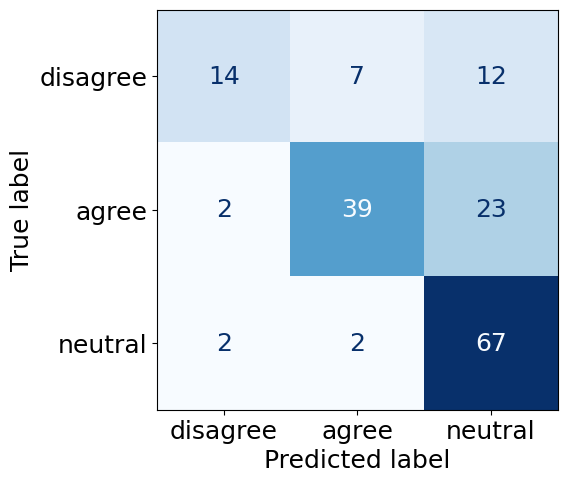

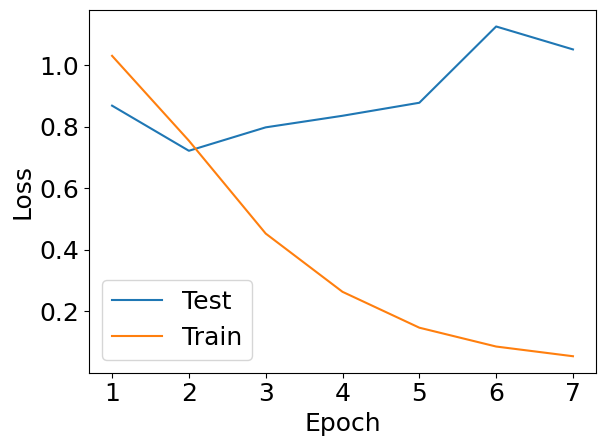

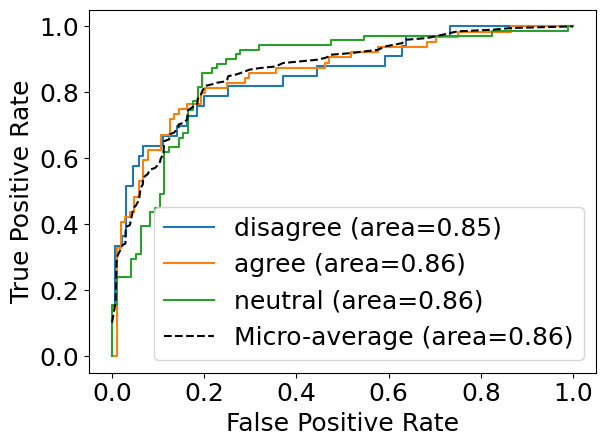

In [16]:
for model_name in ['bert_aug_before']:
# for model_name in experiments.keys():
    print(model_name)
    log = get_model_log(model_name)
    best_ckpt_path = get_model_best_ckpt_path(model_name)


    y_true = get_y_true(model_name)
    y_pred = get_y_pred(model_name, best_ckpt_path)

    y_true_one_hot = get_y_true_one_hot(model_name)
    y_pred_probs = get_y_pred_prob(model_name, best_ckpt_path)

    print('predictions made')

    labels = list(label2id.keys())

    folderpath = dir_diagrams / 'evaluation'

    make_conf_matrix(y_true, y_pred, labels,
                            save=True, folderpath = folderpath, filename=f'conf_matrix_{model_name}')
    make_classification_report(y_true, y_pred, labels,
                            save=True, folderpath = folderpath, filename=f'class_report_{model_name}')
    make_loss_per_epoch(log,
                            save=True, folderpath = folderpath, filename = f'loss_{model_name}')
    make_roc_curve(y_true_one_hot, y_pred_probs, labels,
                            save=True, folderpath = folderpath, filename = f'roc_{model_name}')

### Troubleshooting custom model (avg-pooling)

In [18]:
model_name = 'bert_aug_4'
folder_path = best_ckpt_path
subset = 'test'

model = AutoModelForSequenceClassification.from_pretrained(folder_path, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(folder_path)

In [11]:
log = get_model_log(model_name)
best_ckpt_path = get_model_best_ckpt_path(model_name)


y_true = get_y_true(model_name)
y_pred = get_y_pred(model_name, best_ckpt_path)

y_true_one_hot = get_y_true_one_hot(model_name)
y_pred_probs = get_y_pred_prob(model_name, best_ckpt_path)

print('predictions made')

labels = list(label2id.keys())

folderpath = dir_diagrams / 'evaluation'

# make_conf_matrix(y_true, y_pred, labels,
#                         save=True, folderpath = folderpath, filename=f'conf_matrix_{model_name}')
# make_classification_report(y_true, y_pred, labels,
#                         save=True, folderpath = folderpath, filename=f'class_report_{model_name}')
# make_loss_per_epoch(log,
#                         save=True, folderpath = folderpath, filename = f'loss_{model_name}')
# make_roc_curve(y_true_one_hot, y_pred_probs, labels,
#                         save=True, folderpath = folderpath, filename = f'roc_{model_name}')

c:\Users\rldek\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


predictions made


In [38]:
from torch.nn.functional import cross_entropy, softmax

def forward_pass_with_label(batch):
    inputs = {k:v for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_prob = softmax(output.logits, dim=-1)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'], reduction='none')

    return {'loss': loss.numpy(),
            'logits': output.logits.numpy(),
            'predicted_label': pred_label.numpy(),
            'pred_prob': pred_prob}

result = experiments[model_name]['dataset_enc'][subset].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [75]:
batch = experiments[model_name]['dataset_enc']['test'][0:6]
inputs = {k:v for k,v in batch.items() if k in tokenizer.model_input_names}

In [71]:
model2 = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
model_path = Path('C:/Users/rldek/Downloads/downloaded models/bert_aug_4/checkpoint-672')
model_local = AutoModelForSequenceClassification.from_pretrained(model_path)

model_local.eval()

batch = experiments[model_name]['dataset_enc']['test'][0:6]
inputs = {k:v for k,v in batch.items() if k in tokenizer.model_input_names}

logits = model_local(**inputs).logits
probs = softmax(logits, dim=-1)
preds = torch.argmax(probs, dim=-1)

In [103]:
model2.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [105]:
model_local

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [97]:
preds

tensor([1, 1, 1, 1, 1, 1])

In [85]:
model2(**inputs).logits

tensor([[-0.0444, -0.0200,  0.0759],
        [-0.0636, -0.0611,  0.1096],
        [-0.1266,  0.0410,  0.1549],
        [-0.0637,  0.0764,  0.1623],
        [-0.0303,  0.0265,  0.1633],
        [-0.0338,  0.0649,  0.1408]], grad_fn=<AddmmBackward0>)

In [39]:
result['pred_prob']

tensor([[0.2908, 0.4604, 0.2488],
        [0.2782, 0.4811, 0.2407],
        [0.2495, 0.4876, 0.2629],
        [0.2817, 0.4851, 0.2333],
        [0.2948, 0.4691, 0.2360],
        [0.3044, 0.4772, 0.2184],
        [0.2566, 0.4783, 0.2651],
        [0.2846, 0.4769, 0.2385],
        [0.2864, 0.4743, 0.2393],
        [0.2937, 0.4716, 0.2347],
        [0.2480, 0.4988, 0.2532],
        [0.2944, 0.4524, 0.2532],
        [0.3083, 0.4520, 0.2397],
        [0.2696, 0.4920, 0.2384],
        [0.2953, 0.4867, 0.2181],
        [0.2881, 0.4715, 0.2403],
        [0.2788, 0.4716, 0.2496],
        [0.3192, 0.4542, 0.2266],
        [0.2140, 0.5135, 0.2726],
        [0.2845, 0.4788, 0.2366],
        [0.2842, 0.4871, 0.2287],
        [0.2261, 0.5370, 0.2369],
        [0.2395, 0.5165, 0.2440],
        [0.2976, 0.4854, 0.2171],
        [0.2111, 0.5492, 0.2397],
        [0.2946, 0.4776, 0.2278],
        [0.2637, 0.5137, 0.2226],
        [0.2806, 0.4970, 0.2224],
        [0.2599, 0.4993, 0.2408],
        [0.236

In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.38      1.00      0.55        64
           2       0.00      0.00      0.00        71

    accuracy                           0.38       168
   macro avg       0.13      0.33      0.18       168
weighted avg       0.15      0.38      0.21       168



c:\Users\rldek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rldek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rldek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Illustrate learning rate schedule

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Text(0.5, 0, 'Steps')

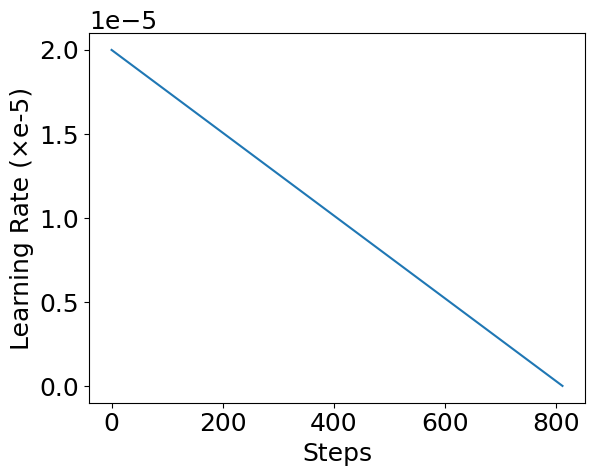

In [ ]:
from torch.utils.data import RandomSampler, DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

model = AutoModelForSequenceClassification.from_pretrained(experiments['bert_base_full']['ckpt'], num_labels=3)

train_sampler = RandomSampler(experiments['bert_base_full']['dataset_enc']['train'])
train_dataloader = DataLoader(experiments['bert_base_full']['dataset_enc']['train'], sampler=train_sampler, batch_size=16)

grad_accum_steps = 1
n_epochs = 7
t_total = len(train_dataloader) // grad_accum_steps * n_epochs

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-6)                                              # $
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, num_training_steps=t_total) # $

lrs=[]
for i in range(t_total):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()
plt.plot(lrs);

plt.ylabel('Learning Rate (×e-5)')
plt.xlabel('Steps')

# Error analysis (RQ3)

In [ ]:
df = pd.read_pickle(data_file)
df['label_prob'] = df[['disagree', 'neutral', 'agree']].max(axis=1)   # extract the probability of the highest probability label

In [ ]:
# get model for predictions

model_name = 'bert_base_full'
log = get_model_log(model_name)
best_ckpt_path = get_model_best_ckpt_path(model_name)

In [ ]:
y_true_probs_all = get_y_true_prob(model_name)
y_pred_probs_all = get_y_pred_prob(model_name, best_ckpt_path)

y_true_probs_label = y_true_probs_all.max(axis=1)
y_pred_probs_label = y_pred_probs_all[np.arange(200), y_true_probs_all.argmax(axis=1)]

# np.abs(y_true_probs_label - y_pred_probs_label)

In [ ]:
model_name = 'bert_base_full'
folder_path = best_ckpt_path
subset = 'test'

model = AutoModelForSequenceClassification.from_pretrained(folder_path, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(folder_path)

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        loss = cross_entropy(output.logits, batch['label'], reduction='none')

    return {'loss': loss.numpy()}

result = experiments[model_name]['dataset_enc'][subset].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
result.set_format('pandas')
df = result[:]

# columns to append to df
cols = ['perc_agreement', 'num_agreement']

# The below code is specific for the full test set
df = pd.concat([df, data_df[data_df['in_held_out_test'] == True][cols].reset_index(drop=True)], axis=1)

In [ ]:
df[['sentence', 'loss', 'perc_agreement']].sort_values('loss', ascending=False).head(20)

,sentence,loss,perc_agreement
183,Harvard climate action plan explicitly recogni...,3.720756,0.750
14,Global temperatures in 2014 shattered earlier ...,3.655679,0.625
24,The Pacific winds are the culprit for slowing ...,3.591613,0.750
153,The Trump administration simply discarded prio...,3.500415,0.625
44,A majority of respondents believe global warmi...,3.446162,0.625
13,The globally averaged sea surface temperature ...,3.346657,0.625
190,Almost all climate scientists think global war...,3.276117,0.625
73,The world is finally on a path toward controll...,3.222814,0.500
9,Global warming is not expected to end anytime ...,3.217400,0.500
193,The carbon impact increased sixfold over the p...,3.063185,0.625


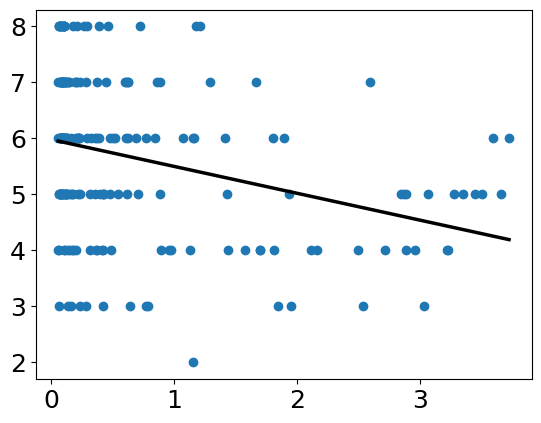

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df['loss'], df['num_agreement'])

b, a = np.polyfit(df['loss'], df['num_agreement'], deg = 1)
xseq = np.linspace(np.min(df['loss']), np.max(df['loss']), num = 100)



ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

In [ ]:
for sent in df.sort_values('loss', ascending=False)['sentence']:
    print(sent)

Harvard climate action plan explicitly recognizes what the science has made clear.
Global temperatures in 2014 shattered earlier records, making 2014 the hottest year since record-keeping began in 1880.
The Pacific winds are the culprit for slowing global warming.
The Trump administration simply discarded prior factual findings related to climate change to support its course reversal.
A majority of respondents believe global warming has already begun.
The globally averaged sea surface temperature for 2013 is among the 10 warmest on record.
Almost all climate scientists think global warming is happening.
The world is finally on a path toward controlling global warming.
Global warming is not expected to end anytime soon.
The carbon impact increased sixfold over the period.
The global climate is at the tail end of a decades-long cooling period.
Regardless of how much corn residue is taken off the field, the process contributes to global warming.
The missed deadline underscores the disdain

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words = 'english')

worst_ngrams_count = vectorizer.fit_transform(df[df['loss'] > 1]['sentence']).toarray()
worst_ngrams_labels = vectorizer.get_feature_names_out()

worst_ngrams = pd.DataFrame(worst_ngrams_count, columns=worst_ngrams_labels)
worst_ngrams = worst_ngrams.sum(axis=0)

worst_ngrams.sort_values(ascending=False).head(20)

global            1.866315
warming           1.782610
global warming    1.702759
climate           1.536523
climate change    0.980207
change            0.980207
carbon            0.935641
years             0.633302
dioxide           0.632056
carbon dioxide    0.632056
year              0.597865
people            0.593511
way               0.546505
period            0.477342
fossil            0.476466
talk              0.464122
end               0.462612
humans            0.453722
arctic            0.437737
scare             0.413240
dtype: float64

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words = 'english')

best_ngrams_count = vectorizer.fit_transform(df[df['loss'] <= 1]['sentence']).toarray()
best_ngrams_labels = vectorizer.get_feature_names_out()

best_ngrams = pd.DataFrame(best_ngrams_count, columns=best_ngrams_labels)
best_ngrams = best_ngrams.sum(axis=0)

best_ngrams.sort_values(ascending=False).head(20)

global              5.643844
warming             4.960003
global warming      4.824796
climate             4.514758
carbon              3.458086
change              3.325201
climate change      3.325201
emissions           2.758869
carbon emissions    1.667036
ice                 1.476900
rise                1.456019
sea                 1.290026
temperatures        1.229780
dioxide             1.226891
carbon dioxide      1.226891
years               1.215589
theory              1.189365
world               1.159003
arctic              1.157969
fossil              1.098637
dtype: float64